In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [4]:
import matplotlib as mpl
mpl.rcParams["font.size"] = 13

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=7, cores=7,walltime='02:00:00') #processes=7, cores=7
#w = cluster.scale(jobs=8)
#
client = Client(cluster)

In [17]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}



tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

print('omega M2:%s'%omega_M2)
print('omega S2:%s'%omega_S2)
print('omega N2:%s'%omega_N2)
print('omega K2:%s'%omega_K2)

omega M2:1.9322736142672448
omega S2:2.0
omega N2:1.8959819677542018
omega K2:2.0054758185413344


In [7]:
root_dir = '/Users/zcaspar/codes/mit4320/'
fig_dir = '/Users/zcaspar/Documents/'+ 'Figures_manuscript/'

#Signal
autocov_hf = xr.open_dataset(root_dir+'cov_hf_bins.nc')
autocov_total = xr.open_dataset(root_dir+'cov_total_bins.nc')

### Autocovariance functions

In [19]:
def th_autocov_MS(tau,V,T):
    return V/2*np.exp(-tau/T)*np.cos((omega_S2-omega_M2)*np.pi*tau)

def th_autocov_MS_mixed(tau,V,T):
    return V/2*(1+0.5*np.exp(-tau/T))*np.cos((omega_S2-omega_M2)*np.pi*tau)

def th_autocov_MS_coh(tau,V,T):
    return V*np.cos((omega_S2-omega_M2)*np.pi*tau)

In [9]:
hf_mean = autocov_hf.mean('draw_bins').compute()
total_mean = autocov_total.mean('draw_bins').compute()

In [11]:
hf_mean = hf_mean.sel(lags=slice(0,150))
total_mean = total_mean.sel(lags=slice(0,150))

In [12]:
tau = total_mean.lags.values

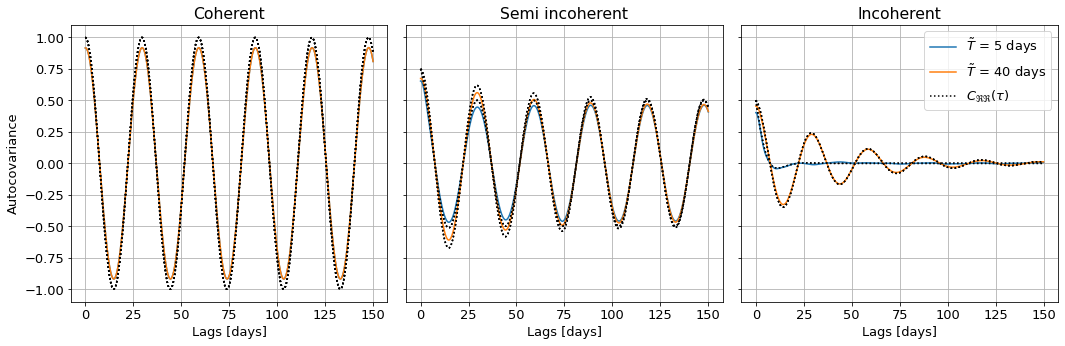

In [33]:
u_hf, Tl, db = 1, 20, 0.4
titles = ['Coherent', 'Semi incoherent', 'Incoherent']
fig, axs = plt.subplots(1,autocov_hf.signal.size, 
                        figsize=(5*autocov_hf.signal.size,5),sharey=True,sharex=True)
for j, s in enumerate(autocov_hf.signal):
    ax = axs[j]
    _ = hf_mean.sel(rms=u_hf,bandwidth=db,signal=s).sel(T=[5,40])
    for t in [5,40]:
        _.MS_real_real.sel(T=t).plot(ax=ax,label = r'$\tilde T$ = %s days'% t)
    ax.grid();ax.set_title(titles[j]);
    ax.set_ylabel('');ax.set_xlabel('')
    axs[0].plot(tau,th_autocov_MS_coh(tau,u_hf,40),c='k',linestyle='dotted')
    axs[1].plot(tau,th_autocov_MS_mixed(tau,u_hf,40),c='k',linestyle='dotted')
    axs[2].plot(tau,th_autocov_MS(tau,u_hf,40),c='k',linestyle='dotted')

    axs[0].plot(tau,th_autocov_MS_coh(tau,u_hf,5),c='k',linestyle='dotted')
    axs[1].plot(tau,th_autocov_MS_mixed(tau,u_hf,5),c='k',linestyle='dotted')
    axs[2].plot(tau,th_autocov_MS(tau,u_hf,5),c='k',linestyle='dotted')
    axs[0].set_ylabel('Autocovariance');
axs[2].plot(tau,th_autocov_MS(tau,u_hf,40),c='k',linestyle='dotted', label=r'$C_{\Re\Re}(\tau)$')
axs[2].legend()
for j in range(3):
    axs[j].set_xlabel('Lags [days]')
fig.tight_layout()
fig.savefig(fig_dir+'autocov_hf_u1.pdf')

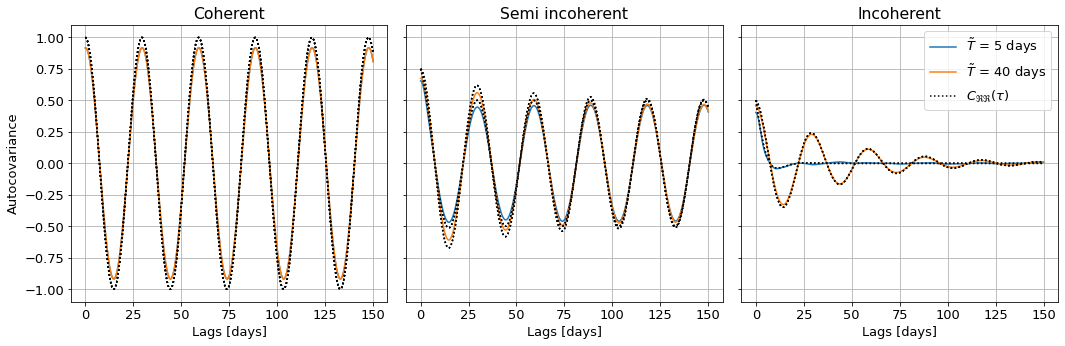

In [34]:
u_hf, Tl, db = 1, 20, 0.4
titles = ['Coherent', 'Semi incoherent', 'Incoherent']
fig, axs = plt.subplots(1,autocov_hf.signal.size, 
                        figsize=(5*autocov_hf.signal.size,5),sharey=True,sharex=True)
for j, s in enumerate(autocov_hf.signal):
    ax = axs[j]
    _ = total_mean.sel(rms=u_hf,bandwidth=db,signal=s,T_low=Tl).sel(T=[5,40])
    for t in [5,40]:
        _.MS_real_real.sel(T=t).plot(ax=ax,label = r'$\tilde T$ = %s days'% t)
    ax.grid();ax.set_title(titles[j]);
    ax.set_ylabel('');ax.set_xlabel('')
    axs[0].plot(tau,th_autocov_MS_coh(tau,u_hf,40),c='k',linestyle='dotted')
    axs[1].plot(tau,th_autocov_MS_mixed(tau,u_hf,40),c='k',linestyle='dotted')
    axs[2].plot(tau,th_autocov_MS(tau,u_hf,40),c='k',linestyle='dotted')

    axs[0].plot(tau,th_autocov_MS_coh(tau,u_hf,5),c='k',linestyle='dotted')
    axs[1].plot(tau,th_autocov_MS_mixed(tau,u_hf,5),c='k',linestyle='dotted')
    axs[2].plot(tau,th_autocov_MS(tau,u_hf,5),c='k',linestyle='dotted')
    axs[0].set_ylabel('Autocovariance');
axs[2].plot(tau,th_autocov_MS(tau,u_hf,40),c='k',linestyle='dotted', label=r'$C_{\Re\Re}(\tau)$')
axs[2].legend()
for j in range(3):
    axs[j].set_xlabel('Lags [days]')
fig.tight_layout()
fig.savefig(fig_dir+'autocov_total_u1.pdf')

In [51]:
u_hf

<xarray.DataArray 'rms' ()>
array(0.)
Coordinates:
    rms      float64 0.0

In [54]:
th_autocov_MS_mixed(tau,u_hf.values,t)

array([0.0075    , 0.00747896, 0.00745751, ..., 0.00443116, 0.00441045,
       0.0043894 ])

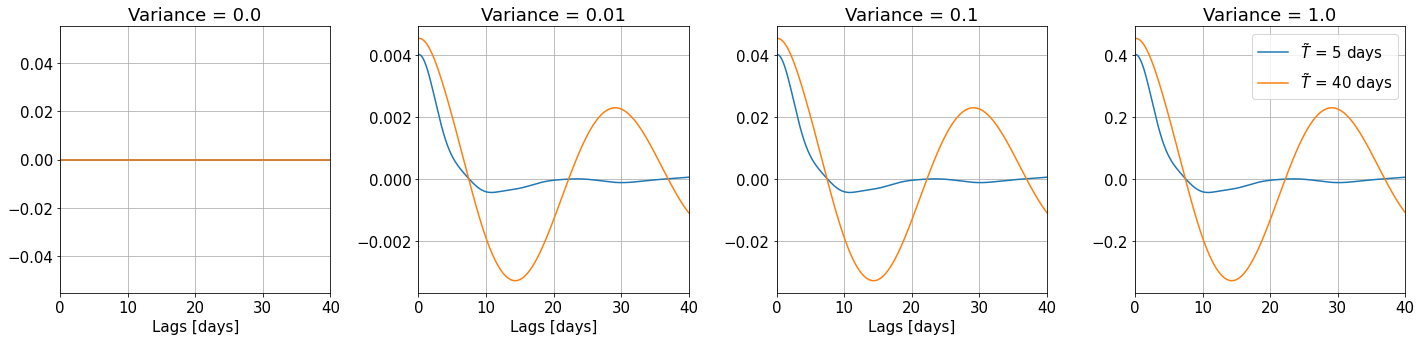

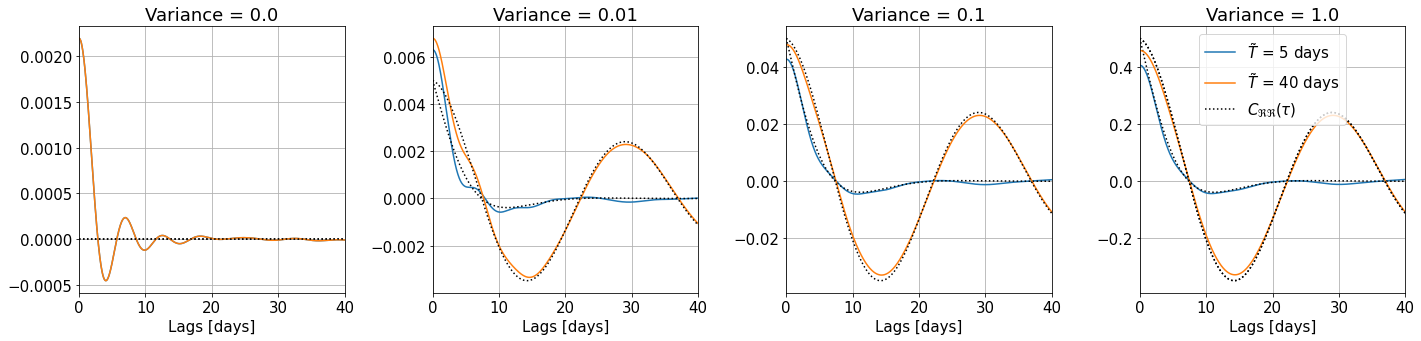

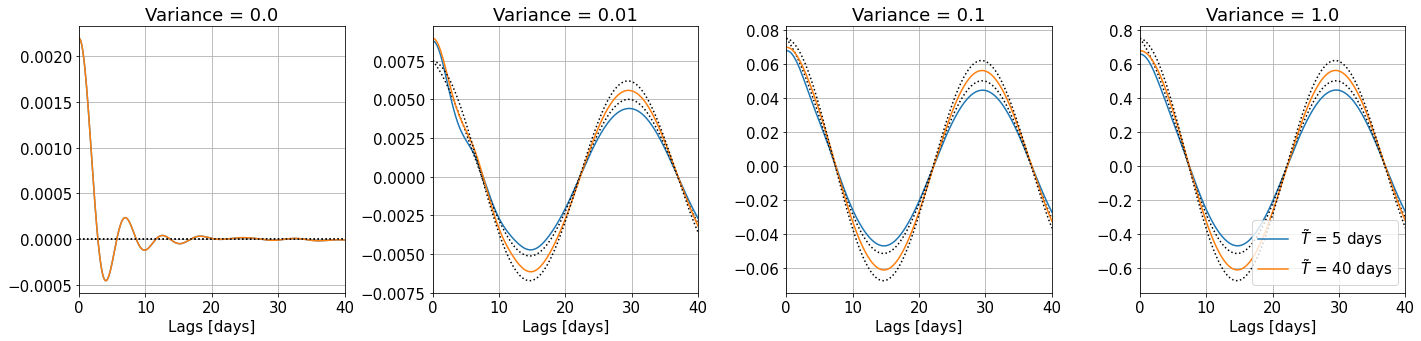

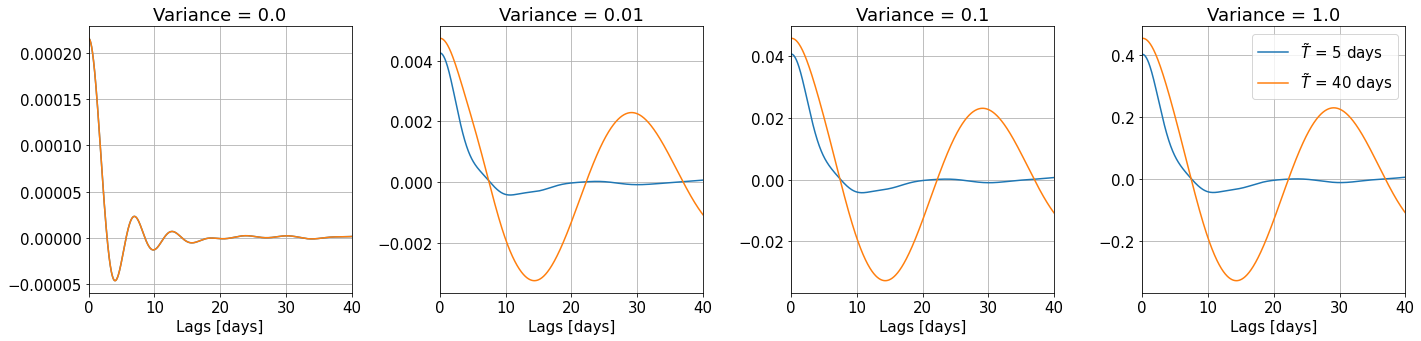

In [59]:
mpl.rcParams["font.size"] = 15
Tl, db = 2, 0.4
titles = ['Coherent', 'Semi incoherent', 'Incoherent']

fig, axs = plt.subplots(1,autocov_hf.rms.size, 
                        figsize=(5*autocov_hf.rms.size,5),sharey=False,sharex=True)
for j, u_hf in enumerate(autocov_hf.rms):
    ax = axs[j]
    _ = hf_mean.sel(rms=u_hf,bandwidth=db,signal='incoherent').sel(T=[5,40])
    for t in [5,40]:
        _.MS_real_real.sel(T=t).plot(ax=ax,label = r'$\tilde T$ = %s days'% t,xlim=(0,40))
    ax.grid();ax.set_title(r'Variance = %s'% u_hf.values);
    ax.set_ylabel('');ax.set_xlabel('')
for j in range(3):
    axs[j].set_xlabel('Lags [days]')
axs[-1].legend()
fig.tight_layout()
#fig.savefig(fig_dir+'autocov_total_u1.pdf')


fig, axs = plt.subplots(1,autocov_hf.rms.size, 
                        figsize=(5*autocov_hf.rms.size,5),sharey=False,sharex=True)
for j, u_hf in enumerate(autocov_hf.rms):
    ax = axs[j]
    _ = total_mean.sel(rms=u_hf,bandwidth=db,signal='incoherent',T_low=Tl).sel(T=[5,40])
    for t in [5,40]:
        _.MS_real_real.sel(T=t).plot(ax=ax,label = r'$\tilde T$ = %s days'% t,xlim=(0,40))
        ax.plot(tau,th_autocov_MS(tau,u_hf.values,t),c='k',linestyle='dotted')
    ax.grid();ax.set_title(r'Variance = %s'% u_hf.values);
    ax.set_ylabel('');ax.set_xlabel('')
for j in range(4):
    axs[j].set_xlabel('Lags [days]')
axs[-1].plot(tau,th_autocov_MS(tau,u_hf.values,t),c='k',linestyle='dotted',label=r'$C_{\Re\Re}(\tau)$')
axs[-1].legend()
fig.tight_layout()
fig.savefig(fig_dir+'autocov_total_Tl5.pdf')

fig, axs = plt.subplots(1,autocov_hf.rms.size, 
                        figsize=(5*autocov_hf.rms.size,5),sharey=False,sharex=True)
for j, u_hf in enumerate(autocov_hf.rms):
    ax = axs[j]
    _ = total_mean.sel(rms=u_hf,bandwidth=db,signal='mixed',T_low=Tl).sel(T=[5,40])
    for t in [5,40]:
        _.MS_real_real.sel(T=t).plot(ax=ax,label = r'$\tilde T$ = %s days'% t,xlim=(0,40))
        ax.plot(tau,th_autocov_MS_mixed(tau,u_hf.values,t),c='k',linestyle='dotted')
    ax.grid();ax.set_title(r'Variance = %s'% u_hf.values);
    ax.set_ylabel('');ax.set_xlabel('')
    
for j in range(4):
    axs[j].set_xlabel('Lags [days]')
axs[-1].legend()
fig.tight_layout()
fig.savefig(fig_dir+'autocov_total_Tl5_mix.pdf')



Tl = 20
fig, axs = plt.subplots(1,autocov_hf.rms.size, 
                        figsize=(5*autocov_hf.rms.size,5),sharey=False,sharex=True)
for j, u_hf in enumerate(autocov_hf.rms):
    ax = axs[j]
    _ = total_mean.sel(rms=u_hf,bandwidth=db,signal='incoherent',T_low=Tl).sel(T=[5,40])
    for t in [5,40]:
        _.MS_real_real.sel(T=t).plot(ax=ax,label = r'$\tilde T$ = %s days'% t,xlim=(0,40))
    ax.grid();ax.set_title(r'Variance = %s'% u_hf.values);
    ax.set_ylabel('');ax.set_xlabel('')
for j in range(4):
    axs[j].set_xlabel('Lags [days]')
axs[-1].legend()
fig.tight_layout()
fig.savefig(fig_dir+'autocov_total_Tl20.pdf')

In [64]:
from inspect import signature
import scipy


# Parameters
myfunc = th_autocov_MS #function to use for the fit
bounds = ((0,0),(2,1000)) # bounds for the fit to avoid non physical results
ce,cl = 'lightseagreen','firebrick'
#tau = ds_mean.lags.values

rad = 2*np.pi

In [65]:
import scipy.optimize

In [87]:
def fit(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['param'],params),
                      'fitted':(['lags'],yfit),
                     'error' : (['param'],np.sqrt(np.diag(cov)))},
                     coords={'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lags.values})
    return out#yfit,params,cov

In [110]:
v = 'MS_real_real'
u_hf = 1
myfunc = th_autocov_MS
i = 1
ds = autocov_hf
myfuncs = [th_autocov_MS_coh,th_autocov_MS_mixed,th_autocov_MS]
Tfit_hf = {}
for i,s in enumerate(ds.signal.values):
    myfunc = myfuncs[i]
    Tfit_hf[s] = xr.concat([xr.combine_nested([[fit(tau,(ds['MS_real_real']
                                ).sel(rms=u_hf,bandwidth=db,signal=s,T=t_,draw_bins=i),myfunc,bounds,norm=False
                                      ) for db in [0.2,0.4,0.6]] for t_ in ds['T'].values]
                                              , concat_dim = ['T','bandwidth']) for i in range(10)
                           ], dim='draw')
    Tfit_hf[s] = Tfit_hf[s].assign_coords({'T': ds['T'].values,
                                           'bandwidth': ds['bandwidth'].values,
                                           'draw': ds['draw_bins'].values})

In [108]:
Tfit_hf['incoherent']

<xarray.Dataset>
Dimensions:    (draw: 10, bandwidth: 3, T: 4, param: 2, lags: 3601)
Coordinates:
  * param      (param) <U1 'V' 'T'
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 149.9 150.0 150.0
  * T          (T) float64 5.0 10.0 20.0 40.0
  * bandwidth  (bandwidth) float64 0.2 0.4 0.6
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    params     (draw, bandwidth, T, param) float64 0.7624 6.989 ... 0.9679 50.59
    fitted     (draw, bandwidth, T, lags) float64 0.3812 0.3789 ... 0.0219
    error      (draw, bandwidth, T, param) float64 0.003921 0.0642 ... 0.05276

In [109]:
trueT = ds['T']
_Tfit = Tfit_hf['incoherent']

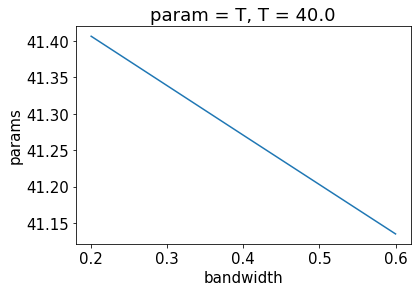

In [118]:
_Tfit.sel(T=40,param='T').params.mean('draw').plot()


In [21]:
import seaborn as sns
fig,axs = plt.subplots(1,_Tfit['T'].size,figsize=(3*_Tfit['T'].size,5))
for i,t in enumerate(_Tfit['T'].values):
    ax = axs[i]
    ax.errorbar(trueT.sel(T=t)+0.001, _Tfit.sel(T=t).mean('draw'),
                yerr=_Tfit.sel(T=t).std('draw'), fmt='o',c='r',linewidth=2
                ,capsize=7,label=r'$\hat{\bar T}$ : fit')
    ax.errorbar(trueT.sel(T=t)-0.001, _T.sel(T=t).mean('draw_bins'),
                yerr=_T.sel(T=t).std('draw_bins'), fmt='o',c='grey',
                capsize=7,label=r'$\hat{\bar T}$ : integral')
    ax.scatter(true_Tbar.sel(T=t),true_Tbar.sel(T=t),c='k',zorder=1,label=r'True value, $\bar T$')
    ax.grid();ax.set_xlabel('Timescale [days]')
    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
    ax.set_title(r'$\overline{T}$ = %s days'%int(t));
    ax.set_xlim(true_Tbar.sel(T=t)-0.0015,true_Tbar.sel(T=t)+0.0015)
ax.legend(bbox_to_anchor=(1,0.6))
axs[0].set_ylabel('Timescale estimates [days]')
fig.tight_layout()

5.0
10.0
20.0
40.0


In [17]:
true_Tbar = ds_mean_total['T']

In [18]:
def Testimate(ds,s,u,myfunc,savefig=False,name=''):
    tau = ds.lags.values
    fig,ax = plt.subplots(1,ds['T'].size,figsize=(5*ds['T'].size,5),sharey=False)
    for i,t in enumerate(ds['T'].values):
        Tbar_fit = xr.concat([fit(tau,ds[v].sel(bandwidth=db,signal=s,T=t,rms=u),myfunc,bounds,norm=False
                             ) for db in ds['bandwidth'].values[:]],dim='bandwidth'
                        ).assign_coords({'bandwidth':ds.bandwidth.values})
        Tbar_v2 = xr.combine_nested([[wrap_v2(ds[v],t,db,s) for s in ds['signal'].values
                                 ] for db in ds.bandwidth.values],concat_dim=['bandwidth','signal']
                       ).assign_coords({'signal':ds.signal.values,'bandwidth':ds.bandwidth.values})
        Tb = Tbar_v2.sel(signal=s,rms=u)#.values
        Tb_fit = Tbar_fit.sel(param='T').params#.values
        (abs(Tb-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
        ).plot(ax=ax[i],c = 'k',marker='.',label=r'$\hat{\overline{T}}$ : integration');
        (abs(Tb_fit-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
         ).plot(ax=ax[i],c = 'r',marker='.',label=r'$\hat{\overline{T}}$ : fit');
        ax[i].grid();ax[i].axhline(0,c='k',linestyle='--',label=r'$\hat{\overline{T}} = \overline{T}$');
       # ax[i].set_title(r'True decorrelation timescale , $\overline{T}$ : %s days'%str(t));
        ax[i].set_title(r'$\frac{\vert\hat{\overline{T}}-\overline{T}\vert}{\overline{T}}$  , with $\overline{T}=$%s days'%str(t));
        ax[i].legend();
    if savefig:
        name = name+s+'_u'+ str(u)+'_T'+str(t)+'.png'
        fig.savefig(fig_dir+name)
    return Tbar_fit

In [19]:
def th_autocov_MS(tau,V,T):
    return V*np.exp(-tau/T)*np.cos((omega_S2-omega_M2)*np.pi*tau)

def th_autocov_MS_mixed(tau,V,T):
    return V*(1+0.5*np.exp(-tau/T))*np.cos((omega_S2-omega_M2)*np.pi*tau)

def th_autocov_MS_coh(tau,V,T):
    return V*np.cos((omega_S2-omega_M2)*np.pi*tau)

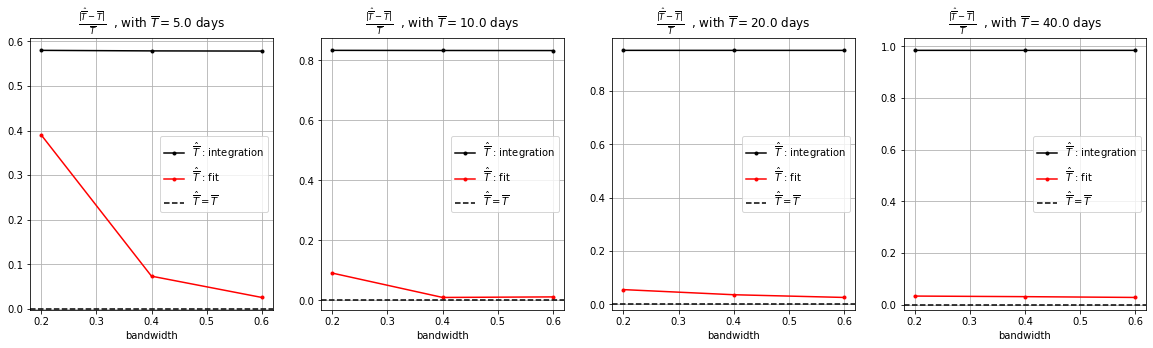

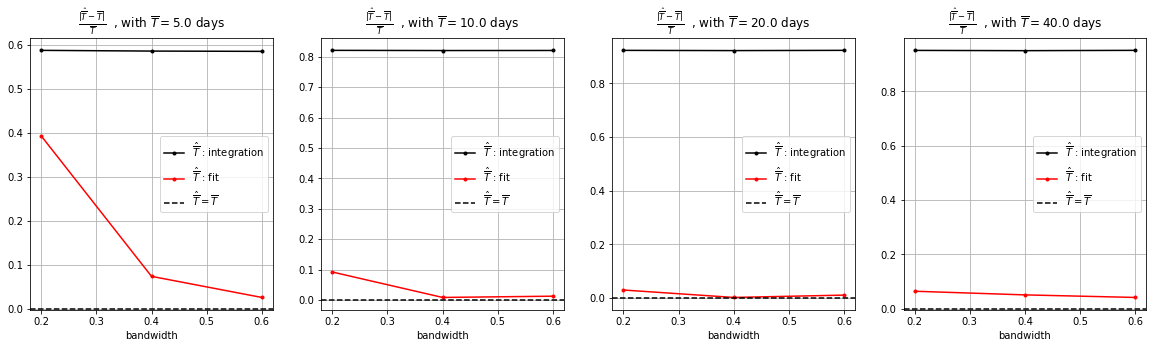

In [20]:
v = 'MS_real_real'
test = Testimate(ds_mean,'incoherent',1,th_autocov_MS,savefig=False)
test = Testimate(ds_mean.sel(lags=slice(0,40)),'incoherent',1,th_autocov_MS,savefig=False,name='lag40_')

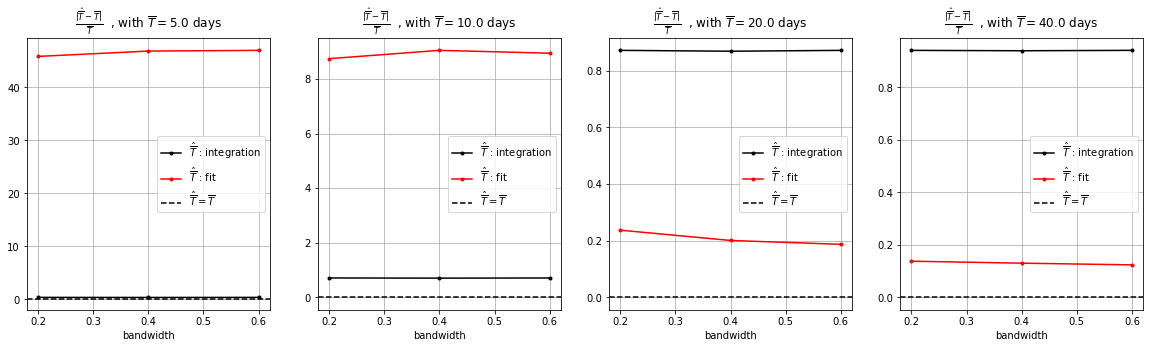

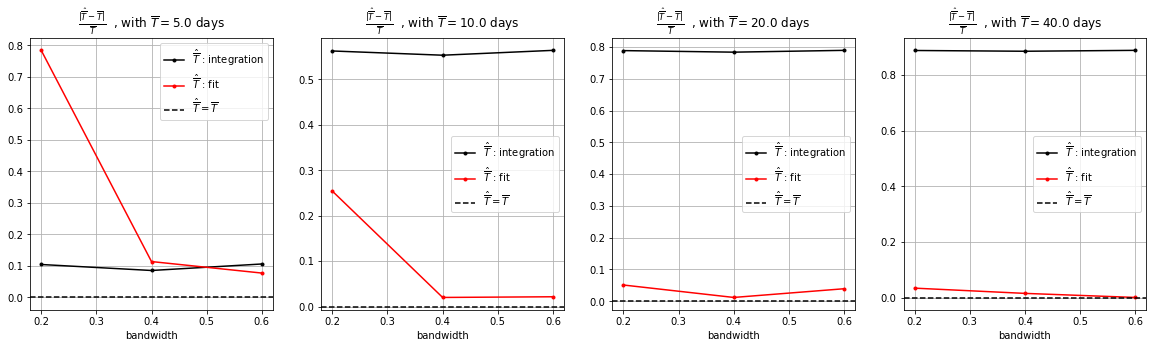

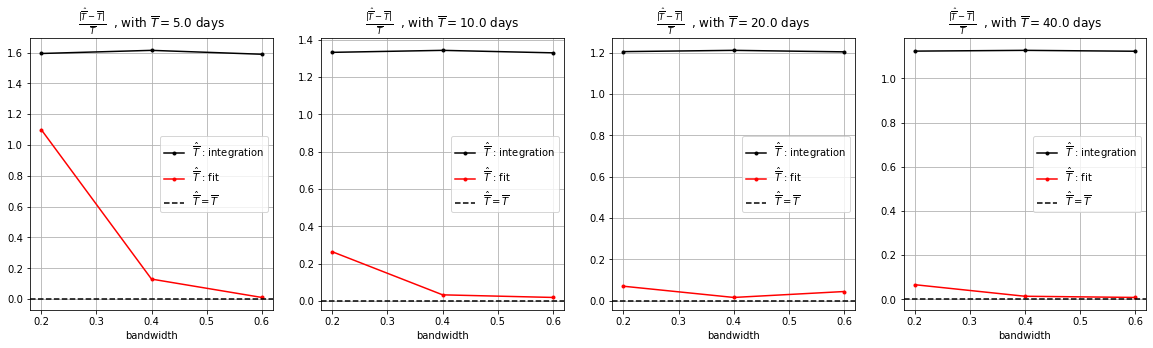

In [27]:
v = 'MS_real_real'
test = Testimate(ds_mean,'mixed',1,th_autocov_MS_mixed,savefig=False)
test = Testimate(ds_mean.sel(lags=slice(0,40)),'mixed',1,th_autocov_MS_mixed,savefig=False,name='lag40_')
test = Testimate(ds_mean.sel(lags=slice(0,20)),'mixed',1,th_autocov_MS_mixed,savefig=False,name='lag40_')

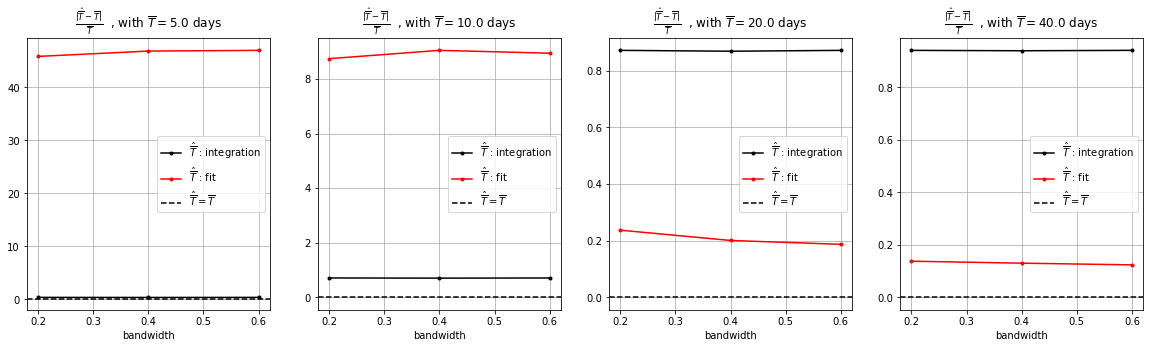

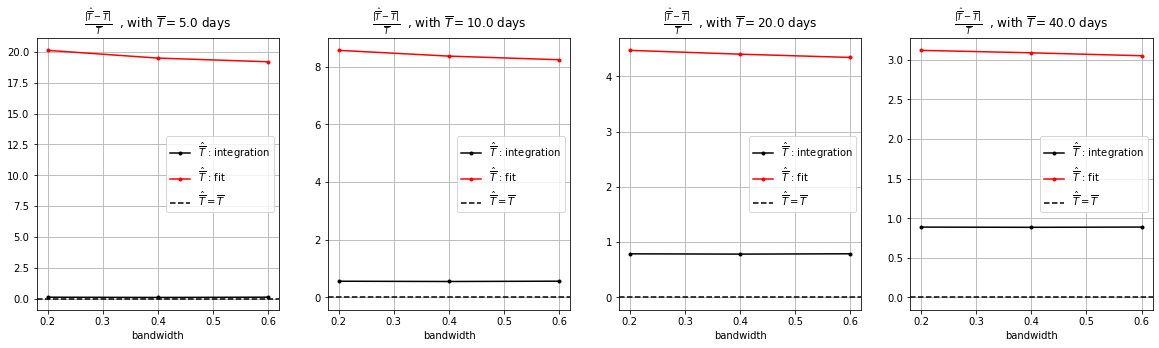

In [21]:
v = 'MS_real_real'
test = Testimate(ds_mean,'mixed',1,th_autocov_MS,savefig=False)
test = Testimate(ds_mean.sel(lags=slice(0,40)),'mixed',1,th_autocov_MS,savefig=False,name='lag40_')
#test = Testimate(ds_mean.sel(lags=slice(0,20)),'mixed',1,th_autocov_MS_mixed,savefig=False,name='lag40_')

In [28]:
def Testimate_total(ds,s,u,myfunc,savefig=False,name=''):
    tau = ds.lags.values
    fig,ax = plt.subplots(1,ds['T'].size,figsize=(5*ds['T'].size,5),sharey=False)
    for i,t in enumerate(ds['T'].values):
        Tbar_fit = xr.concat([fit(tau,ds[v].sel(bandwidth=db,signal=s,T=t,rms=u,T_low=Tl),myfunc,bounds,norm=False
                             ) for db in ds['bandwidth'].values[:]],dim='bandwidth'
                        ).assign_coords({'bandwidth':ds.bandwidth.values})
        Tbar_v2 = xr.combine_nested([[wrap_v2(ds[v],t,db,s) for s in ds['signal'].values
                                 ] for db in ds.bandwidth.values],concat_dim=['bandwidth','signal']
                       ).assign_coords({'signal':ds.signal.values,'bandwidth':ds.bandwidth.values})
        Tb = Tbar_v2.sel(signal=s,rms=u,T_low=Tl)#.values
        Tb_fit = Tbar_fit.sel(param='T').params#.values
        (abs(Tb-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
        ).plot(ax=ax[i],c = 'k',marker='.',label=r'$\hat{\overline{T}}$ : integration');
        (abs(Tb_fit-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
         ).plot(ax=ax[i],c = 'r',marker='.',label=r'$\hat{\overline{T}}$ : fit');
        ax[i].grid();ax[i].axhline(0,c='k',linestyle='--',label=r'$\hat{\overline{T}} = \overline{T}$');
       # ax[i].set_title(r'True decorrelation timescale , $\overline{T}$ : %s days'%str(t));
        ax[i].set_title(r'$\frac{\vert\hat{\overline{T}}-\overline{T}\vert}{\overline{T}}$  , with $\overline{T}=$%s days'%str(t));
        ax[i].legend();
    if savefig:
        name = name+s+'_u'+ str(u)+'_T'+str(t)+'.png'
        fig.savefig(fig_dir+name)
    return Tbar_fit

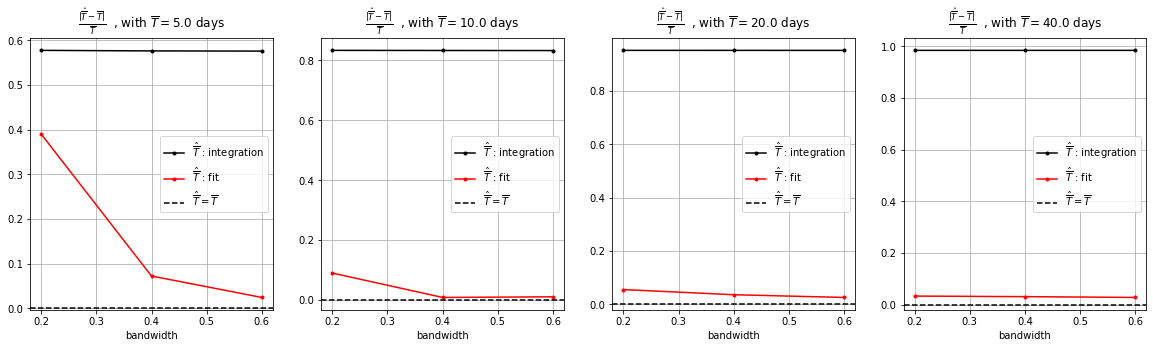

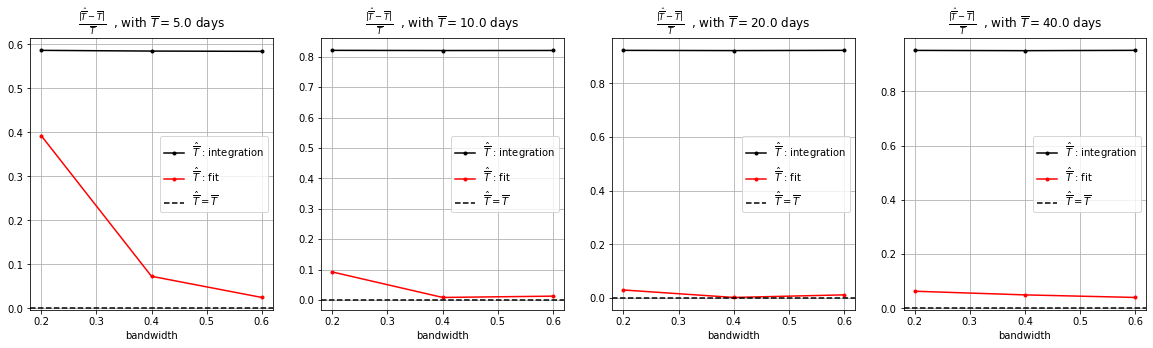

In [29]:
v = 'MS_real_real'
Tl = 20
u = 1
test = Testimate_total(ds_mean_total,'incoherent',u,th_autocov_MS,savefig=False,name='total_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'incoherent',u,th_autocov_MS,savefig=False,name='total_lag40_')

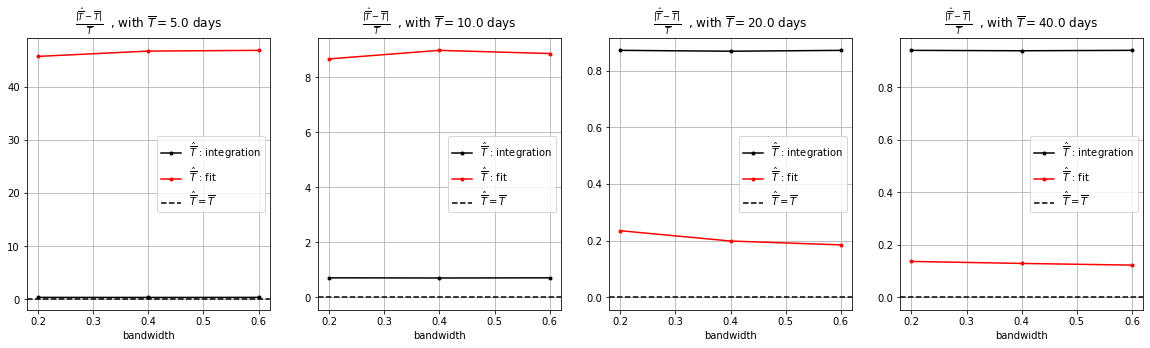

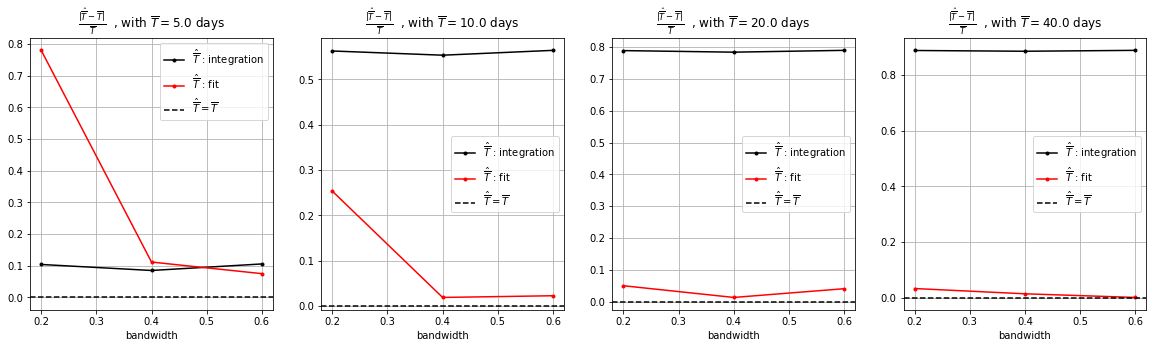

In [30]:
test = Testimate_total(ds_mean_total,'mixed',u,th_autocov_MS_mixed,savefig=False,name='mixed_total_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'mixed',u,
                       th_autocov_MS_mixed,savefig=False,name='mixed_total_lag40_')

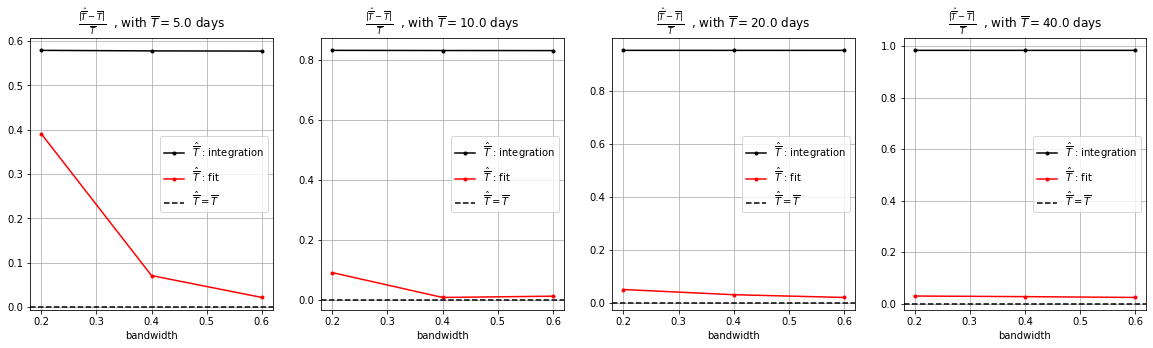

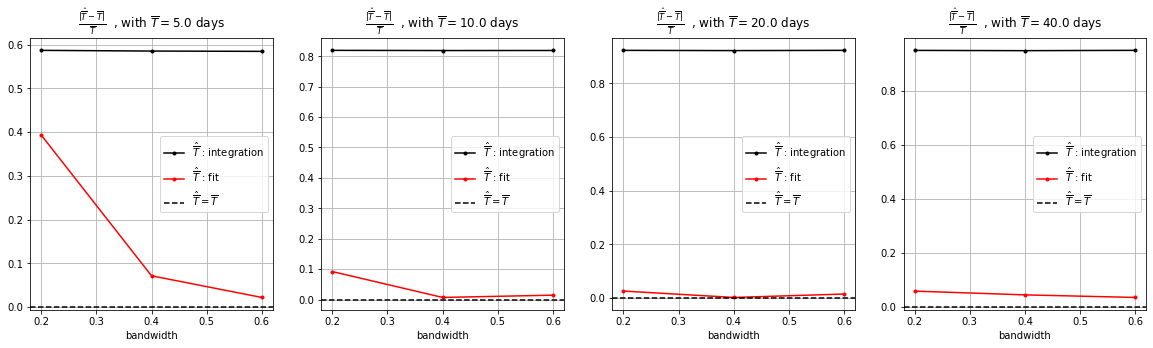

In [31]:
Tl = 2
test = Testimate_total(ds_mean_total,'incoherent',u,th_autocov_MS,savefig=False,name='total_T2_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'incoherent',u,
                       th_autocov_MS,savefig=False,name='total_T2_lag40_')

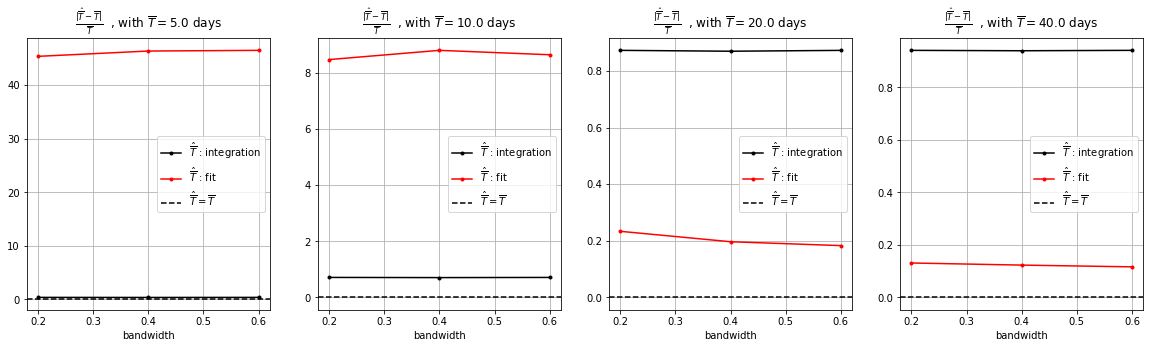

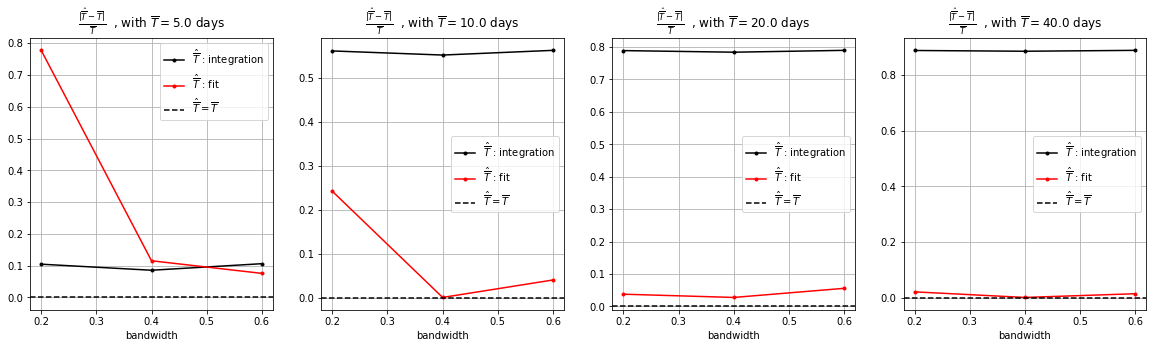

In [32]:
Tl = 2
test = Testimate_total(ds_mean_total,'mixed',u,th_autocov_MS_mixed,savefig=False,name='mixed_total_T2_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'mixed',u,
                       th_autocov_MS_mixed,savefig=False,name='mixed_total_T2_lag40_')

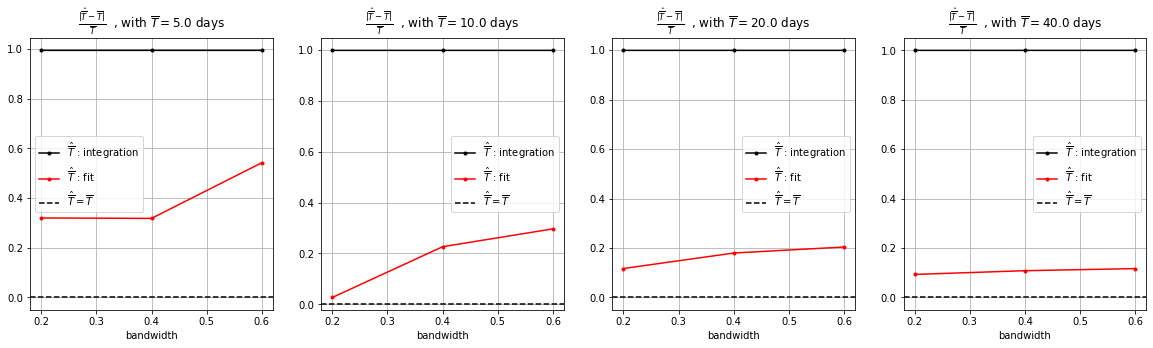

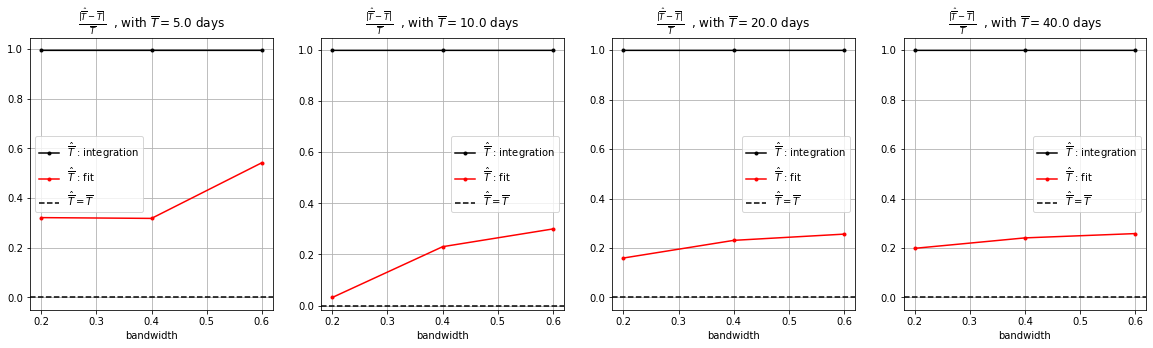

In [33]:
Tl = 2
u = 0.01
test = Testimate_total(ds_mean_total,'incoherent',u,th_autocov_MS,savefig=False,name='total_Tl2_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'incoherent',u,th_autocov_MS,savefig=False,name='total_Tl2_lag40_')

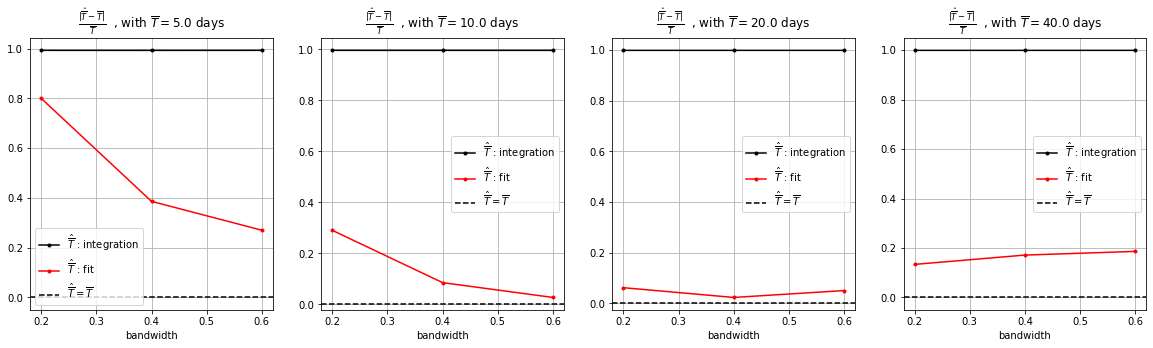

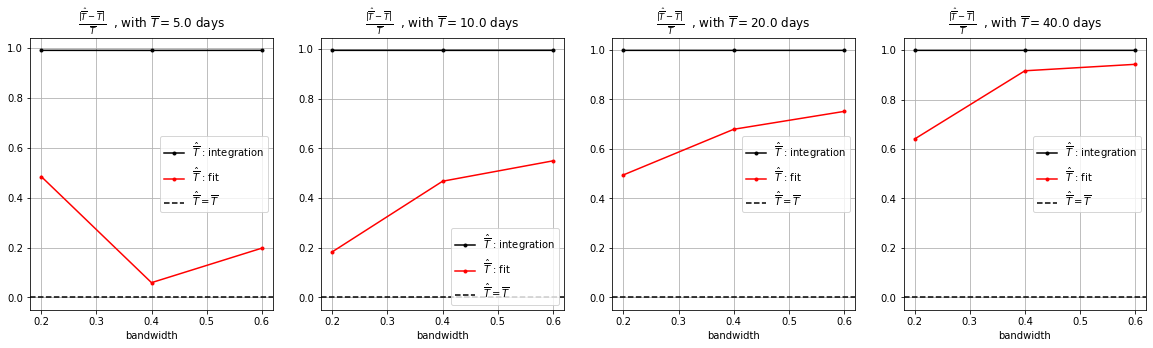

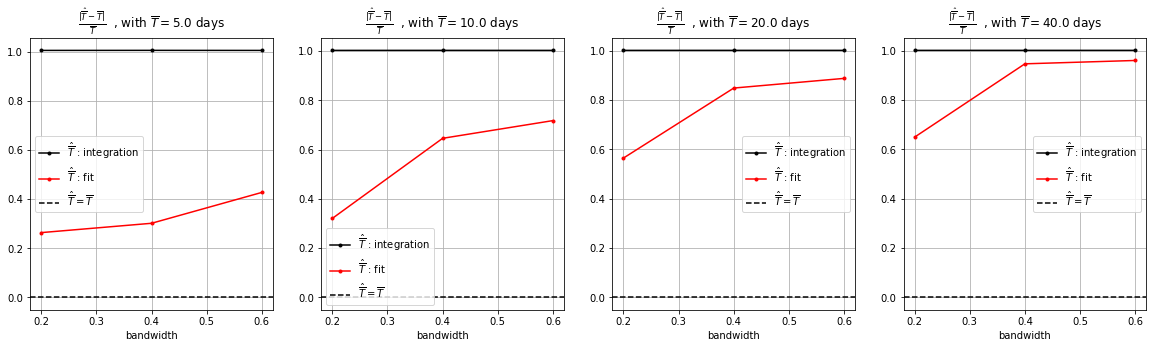

In [35]:
test = Testimate_total(ds_mean_total,'mixed',u,th_autocov_MS_mixed,savefig=False,name='mixed_total_Tl2_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'mixed',u,
                       th_autocov_MS_mixed,savefig=False,name='mixed_total_Tl2_lag40_')

test = Testimate_total(ds_mean_total.sel(lags=slice(0,20)),'mixed',u,
                       th_autocov_MS_mixed,savefig=False,name='mixed_total_Tl2_lag40_')

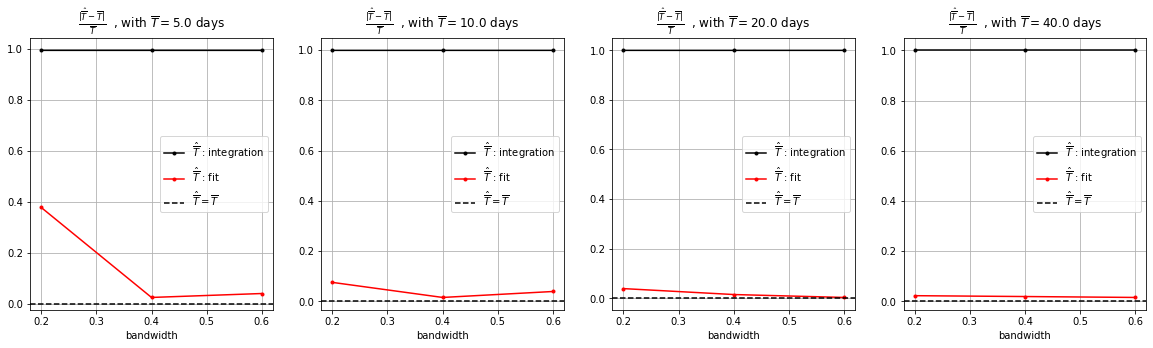

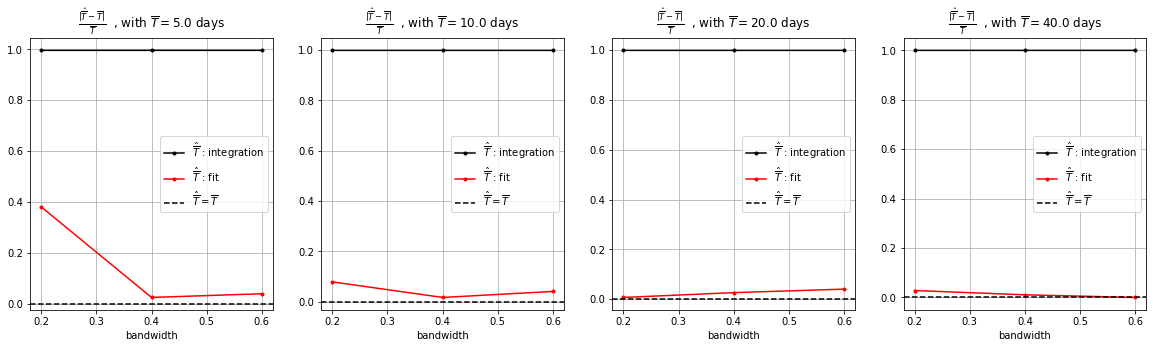

In [63]:
Tl = 20
test = Testimate_total(ds_mean_total,'incoherent',u,th_autocov_MS,savefig=False,name='total_Tl20_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'incoherent',u,th_autocov_MS,savefig=False,name='total_Tl20_lag40_')

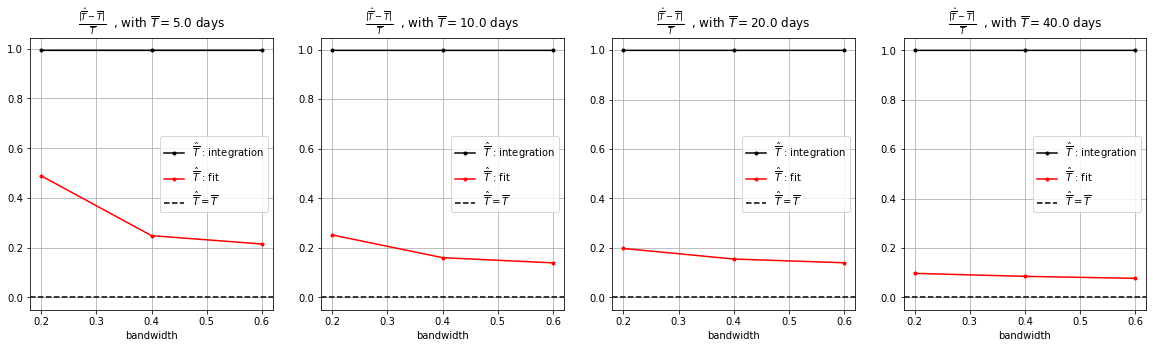

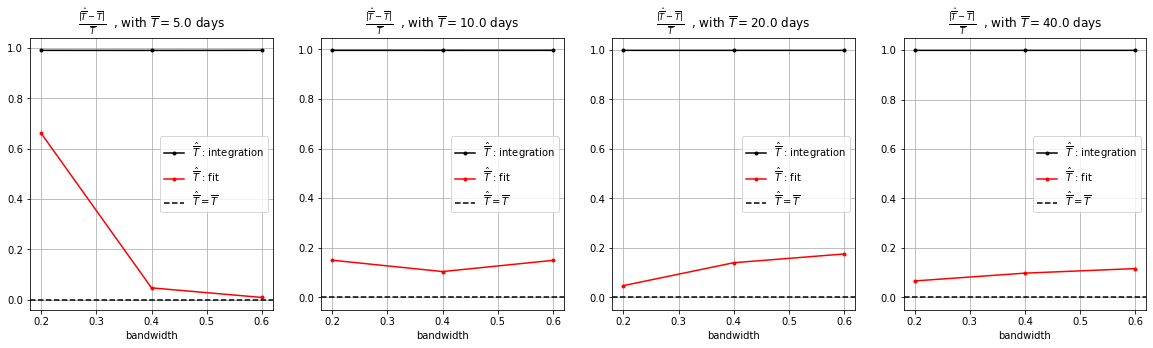

In [64]:
test = Testimate_total(ds_mean_total,'mixed',u,th_autocov_MS_mixed,savefig=False,name='mixed_total_Tl20_')
test = Testimate_total(ds_mean_total.sel(lags=slice(0,40)),'mixed',u,
                       th_autocov_MS_mixed,savefig=False,name='mixed_total_Tl20_lag40_')

In [4]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
